Following https://www.tensorflow.org/tutorials/images/transfer_learning tutorial

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory


In [53]:
tf.__version__

'2.4.0'

In [54]:
# # from tensorflow.compat.v1 import ConfigProto
# # from tensorflow.compat.v1 import InteractiveSession

# # config = ConfigProto()
# # config.gpu_options.allow_growth = True
# # session = InteractiveSession(config=config)

# #SOLUTION

# if 'session' in locals() and session is not None:
#     print('Close interactive session')
#     session.close()

In [55]:
# Step 1: Loading in Dataset
ds_directory = '/home/zrarnz/9-Projects/ECET380/Fish_Dataset/fishset2'
os.listdir(ds_directory)

['Sea Bass',
 'Trout',
 'Striped Red Mullet',
 'README.txt',
 'Hourse Mackerel',
 'Red Sea Bream',
 'Black Sea Sprat',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Mullet',
 'Segmentation_example_script.m',
 'license.txt']

In [56]:
labels=[d for d in os.listdir(ds_directory) if os.path.isdir(os.path.join(ds_directory, d))]
labels

['Sea Bass',
 'Trout',
 'Striped Red Mullet',
 'Hourse Mackerel',
 'Red Sea Bream',
 'Black Sea Sprat',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Mullet']

In [57]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [58]:
dataset = image_dataset_from_directory(ds_directory, 
                                       shuffle=True,
                                       batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE,
                                      labels="inferred",
                                      label_mode='int')

Found 9000 files belonging to 9 classes.


In [59]:
# def gstocolor(raw_img, label):
#     return tf.io.decode_image(raw_img, expand_animations = False, dtype=tf.float32, channels=3), label

In [60]:
# dataset = dataset.map(gstocolor).batch(batch_size).prefetch(1)


In [61]:
train_size = int(0.7 * 9000.0 / 32.0)
val_size = int(0.15 * 9000.0 / 32.0)
test_size = int(0.15 * 9000.0 / 32.0)

# dataset = dataset.shuffle(1000)
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size)
val_set = test_set.take(val_size)
test_set = test_set.skip(val_size)

print(train_size, val_size, test_size)

196 42 42


In [62]:
print('Number of dataset batches: %d' % tf.data.experimental.cardinality(dataset))
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))


print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of dataset batches: 282
Number of fullset batches: 196
Number of validation batches: 42
Number of test batches: 44


In [82]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,

                                               weights='imagenet')

In [83]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_set.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_set.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_set.prefetch(buffer_size=AUTOTUNE)

In [84]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

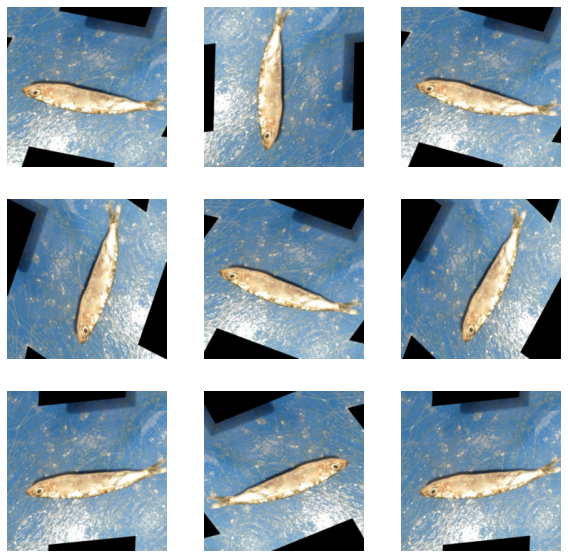

In [85]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [86]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [87]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [88]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 1280)


In [89]:
image_batch.shape

TensorShape([32, 224, 224, 3])

In [90]:
base_model.trainable = False

In [91]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
_____________________________________________________________________________________

In [92]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [93]:
prediction_layer = tf.keras.layers.Dense(9)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 9)


In [94]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [95]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [96]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 11529     
Total params: 4,061,100
Trainable params: 11,529
Non-trainable params: 4,049,571
____________________________________________

In [97]:
len(model.trainable_variables)

2

In [98]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

42/42 [==============================] - 66s 261ms/step - loss: 11.0870 - accuracy: 0.1113


In [99]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 11.10
initial accuracy: 0.10


In [100]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
196/196 [==============================] - 131s 636ms/step - loss: 7.3113 - accuracy: 0.2334 - val_loss: 2.5590 - val_accuracy: 0.3504
Epoch 2/10
196/196 [==============================] - 135s 677ms/step - loss: 2.6828 - accuracy: 0.3291 - val_loss: 2.0664 - val_accuracy: 0.3750
Epoch 3/10
196/196 [==============================] - 137s 691ms/step - loss: 2.2815 - accuracy: 0.3230 - val_loss: 2.0331 - val_accuracy: 0.3586
Epoch 4/10
196/196 [==============================] - 134s 677ms/step - loss: 2.1573 - accuracy: 0.3332 - val_loss: 2.0419 - val_accuracy: 0.3735
Epoch 5/10
196/196 [==============================] - 125s 629ms/step - loss: 2.1246 - accuracy: 0.3332 - val_loss: 2.0566 - val_accuracy: 0.3609
Epoch 6/10
196/196 [==============================] - 128s 643ms/step - loss: 2.1332 - accuracy: 0.3173 - val_loss: 2.0599 - val_accuracy: 0.3616
Epoch 7/10
196/196 [==============================] - 123s 619ms/step - loss: 2.1419 - accuracy: 0.3281 - val_loss: 2.0550 -

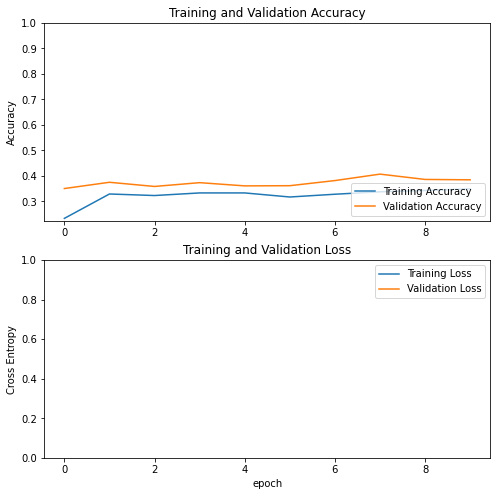

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()